In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from __init__ import *

utils.rng.set_seed()
device = utils.gpu.set_devices(0)

In [3]:
# Import data
classes = 100
tf = [transforms.Grayscale()]
train = datasets.get_cifar(classes, transform=tf)
test = datasets.get_cifar(classes, transform=tf, train=False)

# Get data parameters
N = len(train)
M = np.prod(train.size)

# Set training parameters and loader
batch_size = 32
epochs = 20
nu = 7.5e-5
loader = torch.utils.data.DataLoader(
    train, batch_size=batch_size, shuffle=True, pin_memory=True
)

# Initialize experiment dictionaries
loss_trace = {}
nets = {}
opts = {}

# Set experiment name
experiment_name = 'ie_deblur_ls'

In [4]:
# Generate Blur
blur = nn.Conv2d(1, 1, 3, 1, 1, bias=False, padding_mode='circular')
blur.weight.data[...] = 1/9
blur.weight.requires_grad = False;

# Generate GPU version
blur_gpu = nn.Conv2d(1, 1, 3, 1, 1, bias=False, padding_mode='circular')
blur_gpu.weight.data[...] = 1/9
blur_gpu.weight.requires_grad = False;
blur_gpu.to(device);

In [5]:
# Initialize dimensions, models, parameters and optimizers
dims_pie = [M] * 3
dims_ae = [M] * 3


model_kwargs = {
    'activation': modules.BiCELU,
    'activation_params': {},
    'device': device
}

nets = {
    "IEL": models.dense.AdjointDense(dims_pie, diagonal=False, type='lie', **model_kwargs),
    "IEC": models.dense.AdjointDense(dims_pie, diagonal=False, type='cayley', **model_kwargs),
    "IELD": models.dense.AdjointDense(dims_pie, diagonal=True, type='lie', **model_kwargs),
    "IECD": models.dense.AdjointDense(dims_pie, diagonal=True, type='cayley', **model_kwargs),
}

for k, model in nets.items():
    loss_trace[k] = {}
    opts[k] = torch.optim.Adam(model.parameters() , lr = nu if k=='AE' else 4*nu)

In [6]:
# Define objective function

def objective_function(x, xh, y=None, yh=None, params=None, l2_lambda=1e-6, alpha=4, reduction='mean'):
    losses = {}

    if params is not None:
        losses['l2'] = torch.tensor(0.).to(x.device)
        for param in params:
            losses['l2'] += torch.norm(param)
        losses['l2'] *= l2_lambda
    
    losses['lx'] = F.mse_loss(xh, x, reduction=reduction)
    if y is not None:
        losses['ly'] = F.mse_loss(yh, y, reduction=reduction)
    losses['l'] = sum(losses.values())
    return losses['l'], losses

In [7]:
# Print no. parameters
print("Number of Parameters:")
for k in nets.keys():
    print(f"No. params {k:5}:  {utils.metrics.no_parameters(nets[k])}")

Number of Parameters:
No. params IEL  :  2099200
No. params IEC  :  2099200
No. params IELD :  2100224
No. params IECD :  2100224


In [8]:
# Set examples for training, testing and visualization
sample_indices_small = np.array([0, 3, 42, 85, 666, 1001, 6969, 31415])

# Convert sample indices to tensors
xims = torch.tensor(train.data[sample_indices_small]).float().mean(-1) / 255
yims = blur(xims[:,None,...])
xs = xims.flatten(-2, -1).to(device)
ys = yims.flatten(-3, -1).to(device)
xt = torch.tensor(test.data).float().mean(-1).flatten(-2, -1).to(device) / 255
yt = blur((torch.tensor(test.data).float().permute(0,3,1,2).mean(1)[:,None,...] / 255)).flatten(-3, -1).to(device)

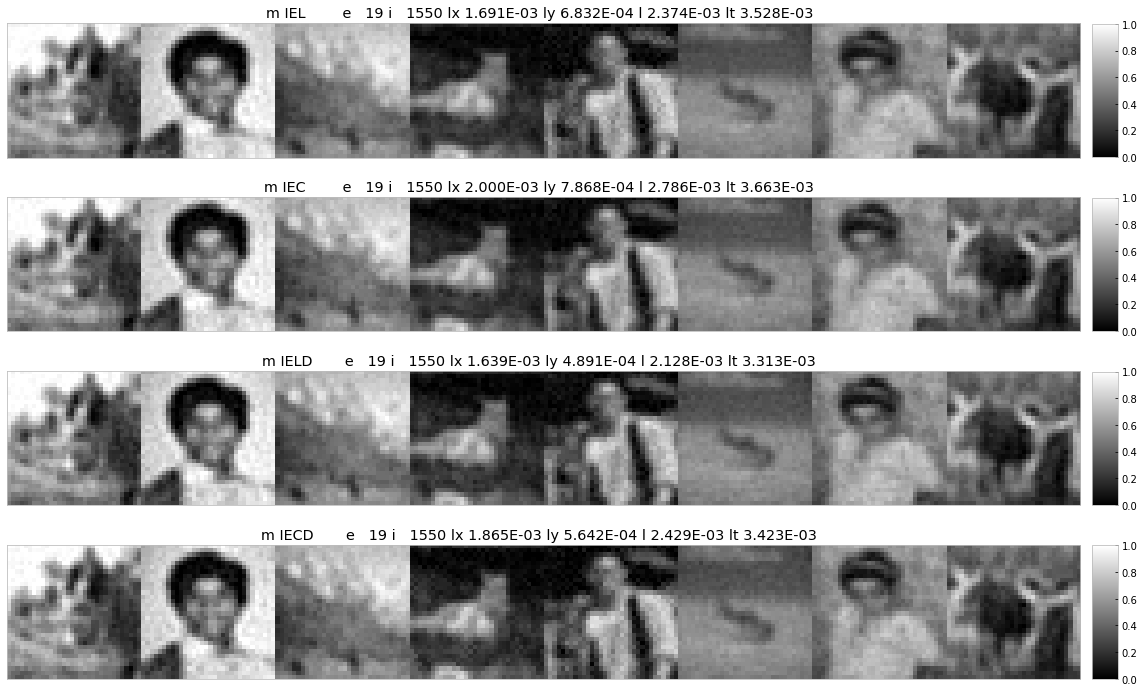

In [9]:
# Training loop

for e in range(epochs):
    i = 0
    for x, _ in loader:
        x = x.to(device)
        with torch.no_grad():
            y = blur_gpu(x).flatten(-3, -1)
        x = x[:,0,:,:].flatten(-2, -1).to(device)
        xhs = {}
        ldicts = {}
        for m, cur in enumerate(nets):
            # Reset gradients and do forward pass
            opts[cur].zero_grad()
            xh = nets[cur].T(y)
            yh = nets[cur](x)            
            loss, ldicts[cur] = objective_function(x, xh, y, yh)

            loss.backward()
            opts[cur].step()
            
            # Validation
            with torch.no_grad():
                yth = nets[cur](xt)
                xth = nets[cur].T(yt)
                ldicts[cur]['lt'] = utils.loss.logcosh(xth, xt, alpha=4, reduction='mean')

            # Reporting
            for k, v in ldicts[cur].items():
                
                if k not in loss_trace[cur]:
                    loss_trace[cur][k] = []

                loss_trace[cur][k].append(v)


        # Plot and Report
        if i % 50 == 0:
            for cur in nets.keys():
                with torch.no_grad():
                    yhs = nets[cur](xs)
                    xhs[cur] = nets[cur].T(ys)
                    xhs[cur] = xhs[cur].to('cpu').unflatten(-1, train.size)
            clear_output(wait=True)
            utils.reporting.plot_training(xhs, e, i, ldicts, cmap='gray', path=experiment_name)
            
        i += 1

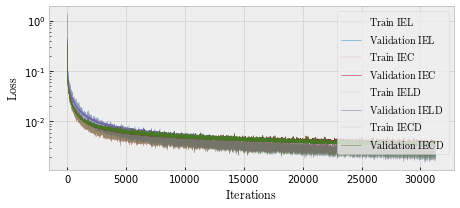

In [10]:
# Convert trace to numpy
np_loss_trace = {}
for k in loss_trace:
    np_loss_trace[k] = {}
    for l in loss_trace[k]:
        np_loss_trace[k][l] = np.array([v.item() for v in loss_trace[k][l]])

# Plot overall loss
for k in nets.keys():
    p = plt.plot(np_loss_trace[k]["l"], linewidth=.3, label=f"$\mathrm{{Train\,\,{k}}}$", alpha=0.4)
    plt.plot(np_loss_trace[k]["lt"], linewidth=.5, label=f"$\mathrm{{Validation\,\,{k}}}$", alpha=0.95, color=p[0].get_color())

plt.legend()
plt.xlabel('$\mathrm{Iterations}$')
plt.ylabel('$\mathrm{Loss}$')
plt.yscale("log")
plt.savefig(f'../figures/training/{experiment_name}.pdf')

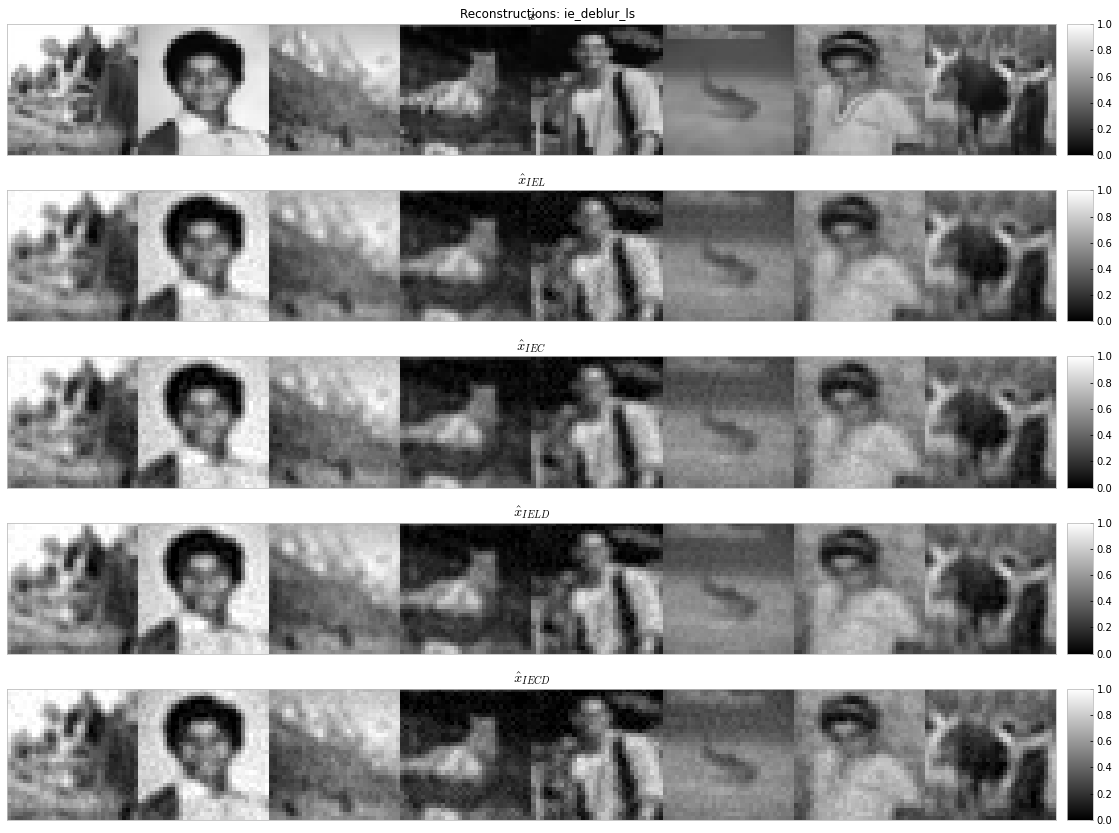

In [11]:
# Move models to GPU
for k in nets:
    nets[k] = nets[k].to(device)

# Plot results
with torch.no_grad():
    xhs = {"": xims}
    
    for k in nets.keys():
        xhs[k] = nets[k].T(ys)
        xhs[k] = xhs[k].to('cpu').unflatten(-1, train.size)
    
utils.reporting.plot_results(xhs, f'Reconstructions: {experiment_name}', cmap='gray', fname=experiment_name)

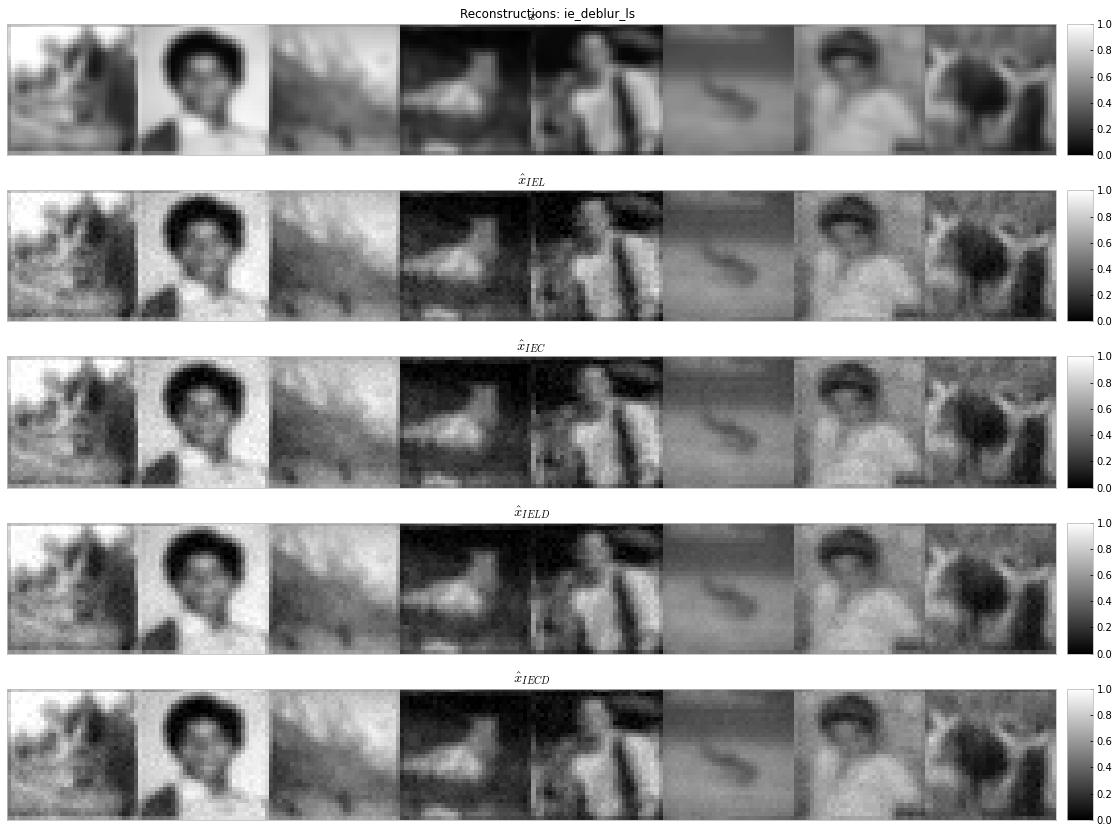

In [12]:
# Move models to GPU
for k in nets:
    nets[k] = nets[k].to(device)

# Plot results
with torch.no_grad():
    xhs = {"": blur(xims[:,None,...])[:,0,...]}
    
    for k in nets.keys():
        xhs[k] = nets[k](xs)
        xhs[k] = xhs[k].to('cpu').unflatten(-1, train.size)
    
utils.reporting.plot_results(xhs, f'Reconstructions: {experiment_name}', cmap='gray', fname=experiment_name)

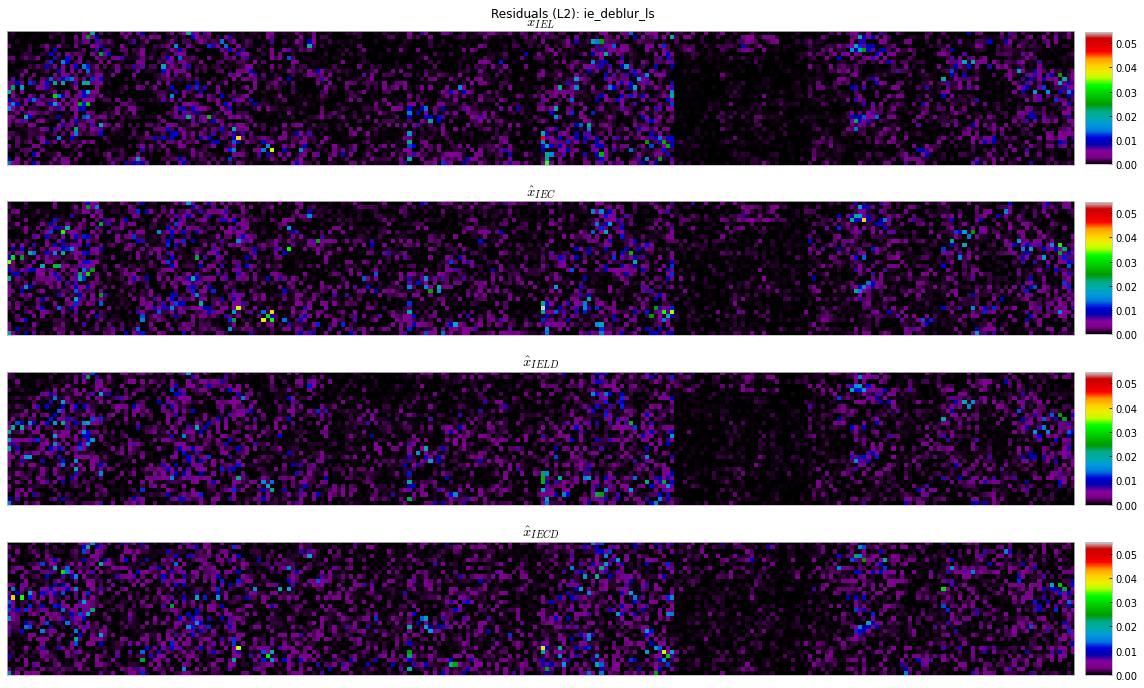

In [13]:
# Plot residuals (L2)
with torch.no_grad():
    xhs = {}
    curmax = 0

    for k in nets.keys():
        xhs[k] = nets[k].T(ys)
        xhs[k] = xhs[k].to('cpu').unflatten(-1, train.size)
        xhs[k] = (xhs[k] - xims)**2
        if torch.max(xhs[k]) > curmax:
            curmax = torch.max(xhs[k])

utils.reporting.plot_results(
    xhs, f'Residuals (L2): {experiment_name}', vmax=curmax, fname=experiment_name + 'res', root='../figures/results/'
)

In [14]:
# Move models to CPU
for cur, model in nets.items():
    nets[cur] = model.to('cpu')
    
torch.cuda.empty_cache()

In [15]:
print(f"Relative Error:")
for k, model in nets.items():
    with torch.no_grad():
        XH = model.T(yt.cpu())
        YH = model(xt.cpu())
        re_x = utils.metrics.relative_error(XH, xt.cpu(), reduction='mean')
        re_y = utils.metrics.relative_error(YH, yt.cpu(), reduction='mean')
        mse_x = F.mse_loss(XH, xt.cpu(), reduction='mean')
        mse_y = F.mse_loss(YH, yt.cpu(), reduction='mean')
    print(
        f"{k:6}: " + 
        f"REx {re_x:4E} " +
        f"REy {re_y:4E} " +
        f"RE  {(re_x + re_y) / 2:4E} " +
        f"MSEx {mse_x:4E} " + 
        f"MSEy {mse_y:4E} " +
        f"MSE  {(mse_x + mse_y) / 2:4E} "
    )

Relative Error:
IEL   : REx 8.138118E-02 REy 5.262529E-02 RE  6.700324E-02 MSEx 1.706332E-03 MSEy 6.894869E-04 MSE  1.197909E-03 
IEC   : REx 8.700838E-02 REy 5.643947E-02 RE  7.172392E-02 MSEx 1.949677E-03 MSEy 7.954944E-04 MSE  1.372586E-03 
IELD  : REx 7.919936E-02 REy 4.523369E-02 RE  6.221652E-02 MSEx 1.618498E-03 MSEy 5.095958E-04 MSE  1.064047E-03 
IECD  : REx 8.386257E-02 REy 4.751623E-02 RE  6.568940E-02 MSEx 1.819692E-03 MSEy 5.659684E-04 MSE  1.192830E-03 


In [16]:
# Calculate PSNR and SSIM on test data
print(f"Image Reconstruction Metrics:")
for k, model in nets.items():
    with torch.no_grad():
        XH = model.T(yt.cpu())
        YH = model(xt.cpu())
        psnr_x = utils.metrics.psnr(xt.cpu(), XH)
        ssim_x = utils.metrics.ssim(
            xt.cpu().unflatten(-1, (32, 32))[:,None,...], 
            XH.unflatten(-1, (32, 32))[:,None,...]
        )
        psnr_y = utils.metrics.psnr(yt.cpu(), YH)
        ssim_y = utils.metrics.ssim(
            yt.cpu().unflatten(-1, (32, 32))[:,None,...], 
            YH.unflatten(-1, (32, 32))[:,None,...]
        )
    print(
        f"{k:6}: " + 
        f"PSNRx: {psnr_x:4E} " +
        f"PSNRy: {psnr_y:4E} " +
        f"PSNR:  {(psnr_y + psnr_x) / 2:4E} " +
        f"SSIMx: {ssim_x:4E} " +
        f"SSIMy: {ssim_y:4E} " +
        f"SSIM:  {(ssim_y + ssim_x) / 2:4E} "
    )

Image Reconstruction Metrics:
IEL   : PSNRx: 2.767937E+01 PSNRy: 3.161474E+01 PSNR:  2.964705E+01 SSIMx: 9.230747E-01 SSIMy: 9.472606E-01 SSIM:  9.351677E-01 
IEC   : PSNRx: 2.710037E+01 PSNRy: 3.099363E+01 PSNR:  2.904700E+01 SSIMx: 9.077685E-01 SSIMy: 9.394318E-01 SSIM:  9.236002E-01 
IELD  : PSNRx: 2.790888E+01 PSNRy: 3.292774E+01 PSNR:  3.041831E+01 SSIMx: 9.233294E-01 SSIMy: 9.581062E-01 SSIM:  9.407178E-01 
IECD  : PSNRx: 2.740002E+01 PSNRy: 3.247208E+01 PSNR:  2.993605E+01 SSIMx: 9.108697E-01 SSIMy: 9.539330E-01 SSIM:  9.324014E-01 


In [18]:
# Move models to GPU
for k in nets:
    nets[k] = nets[k].to(device)

# Estimate Condition Number using Adverserial Perturbation
rs = {}
opts_p = {}
epochs = 3
loss_trace_p = {}
for k in nets.keys():
    loss_trace_p[k] = {'l': [], 'lphi': []}
    rs[k] = nn.Parameter(torch.randn(M).to(device))
    _zs = torch.sum(rs[k] == 0)
    while _zs > 0:
        rs[k][rs[k] == 0] = nn.Parameter(torch.random.randn(_zs))
        _zs = torch.sum(rs[k] == 0)
    nets[k].eval()
    opts_p[k] = torch.optim.Adam([rs[k]])

In [19]:
# Define Perturbation Objective
def perturbation_objective(xe, xh):
    losses = {}
    
    lphi = -F.mse_loss(xe, xh)
    losses['lphi'] = lphi

    return sum(losses.values()), losses

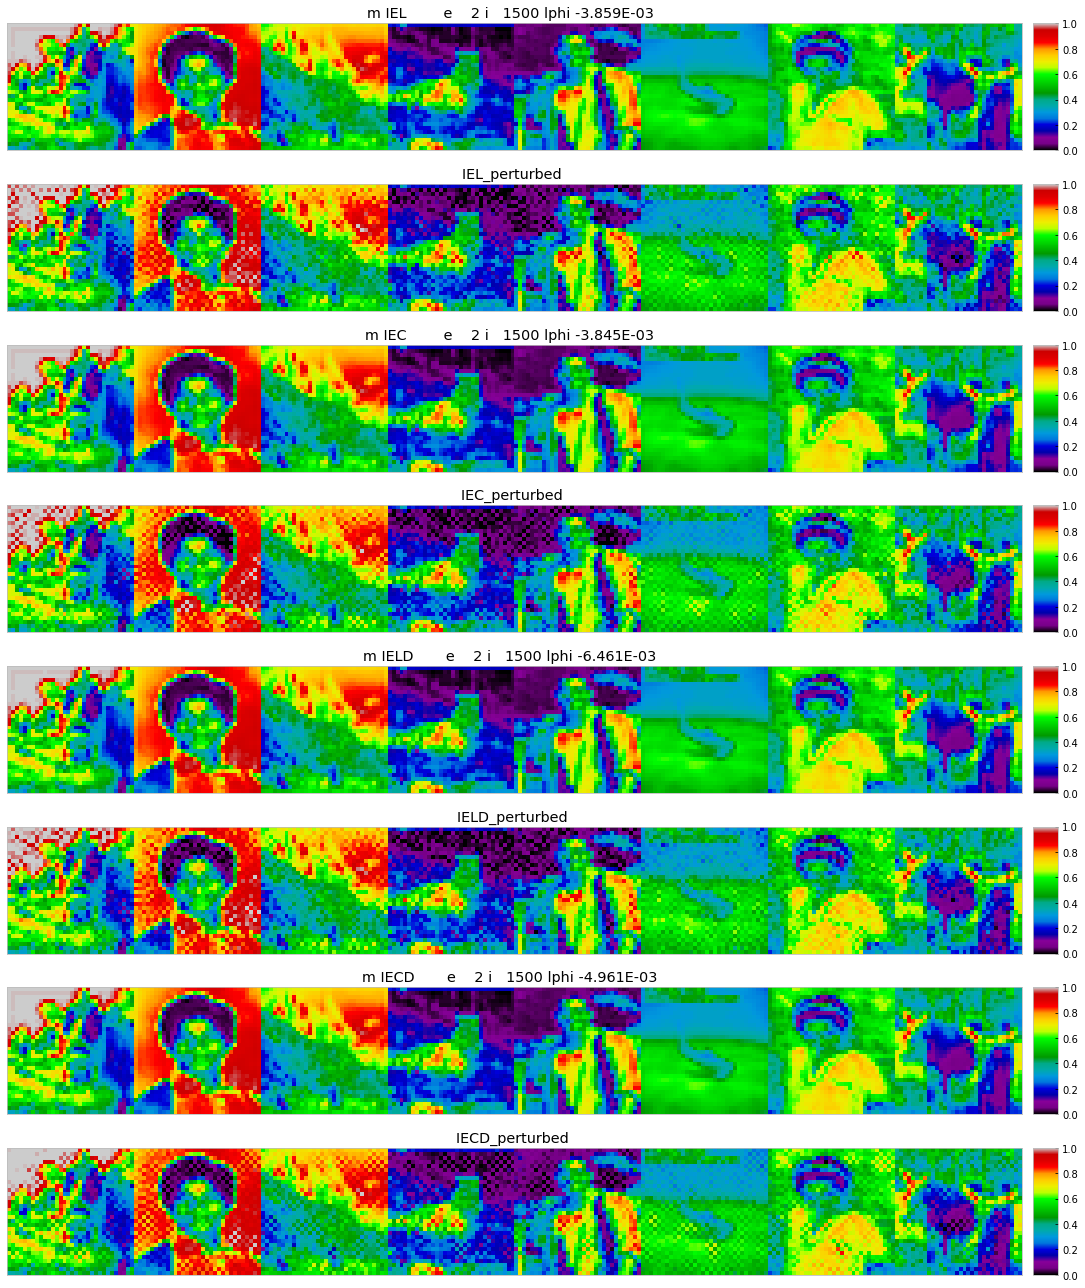

In [20]:
# Training loop

for e in range(epochs):
    i = 0
    for x, y in loader:
        x = x[:,0,:,:].flatten(-2, -1).to(device)
        xhs = {}
        ldicts = {}
        for m, cur in enumerate(nets):
            # Reset gradients and do forward pass
            opts_p[cur].zero_grad()
            r = utils.projection.project_into_ball(rs[cur], 1, 2)

            xh = nets[cur](x)
            xe = nets[cur](x + r)

            # Calculate loss
            loss, ldicts[cur] = perturbation_objective(xe, xh)

            loss.backward()
            opts_p[cur].step()
            
            # Reporting
            for k, v in ldicts[cur].items():
                
                if k not in loss_trace_p[cur]:
                    loss_trace[cur][k] = []

                loss_trace_p[cur][k].append(v)


        # Plot and Report
        if i % 500 == 0:
            for cur in nets.keys():
                with torch.no_grad():
                    per = f'{cur}_perturbed'
                    r = utils.projection.project_into_ball(rs[cur], 1, 2)

                    xhs[cur] = nets[cur].T(nets[cur](xs))
                    xhs[cur] = xhs[cur].to('cpu').unflatten(-1, train.size)
                    xhs[per] = nets[cur].T(nets[cur](xs + r))
                    xhs[per] = xhs[per].to('cpu').unflatten(-1, train.size)
            clear_output(wait=True)
            utils.reporting.plot_training(xhs, e, i, ldicts, save=False)            
        i += 1

In [21]:
# Move models to CPU
for cur, model in nets.items():
    nets[cur] = model.to('cpu')

print(f"Relative Cond:")

for k, model in nets.items():
    r = utils.projection.project_into_ball(rs[k].cpu(), 1, 2)
    XE = model.T(model(xt.cpu() + r))
    XH = model.T(model(xt.cpu()))

    rerr_psi = utils.metrics.relative_error(XH, XE, reduction='mean')
    rerr_x = utils.metrics.relative_error(xt.cpu(), xt.cpu() + r, reduction='mean')
    cond_no = utils.metrics.relative_cond_no(XH, XE, xt.cpu(), r, reduction='mean')
    
    print(f"{k:6}: {rerr_psi.item():2.6f} {rerr_x.item():2.6f} {cond_no.item():2.6f}")

Relative Cond:
IEL   : 0.065053 0.065052 3.511109
IEC   : 0.065052 0.065052 3.511050
IELD  : 0.065054 0.065052 3.511137
IECD  : 0.065052 0.065052 3.511050


In [22]:
# Save models

serialized_path = f'../serialized/experiments/{experiment_name}/'
if not os.path.isdir(serialized_path):
    os.mkdir(serialized_path)

for name, model in nets.items():
    with open(f'{serialized_path}{name}.pt', 'wb') as outfile:
        torch.save(model, outfile)

In [23]:
# Save training results

with open(f'{serialized_path}training.pickle', 'wb') as outfile:
    pickle.dump(np_loss_trace, outfile)

In [24]:
# Load models

serialized_path = f'../serialized/experiments/{experiment_name}/'
for name, model in nets.items():
    with open(f'{serialized_path}{name}.pt', 'rb') as outfile:
        nets[name] = torch.load(outfile)

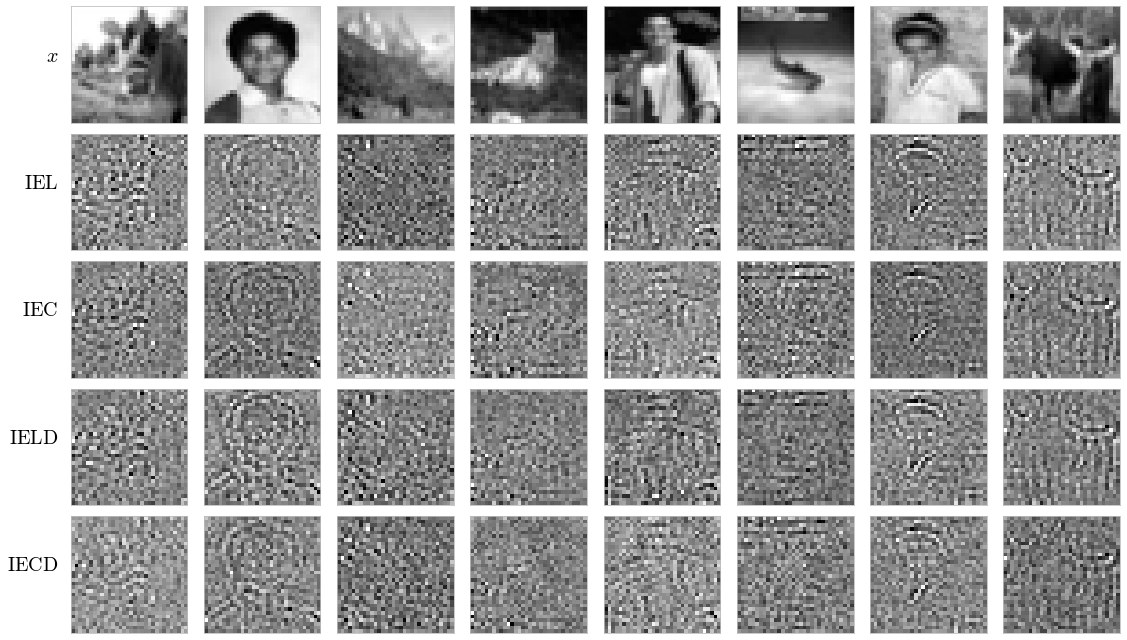

In [25]:
fig, ax = plt.subplots(len(nets)+1, 8, figsize=(16,9))

for j, cur in enumerate(nets):
    _xx = xs.clone().cpu()
    _yy = ys.clone().cpu()
    _xx.requires_grad = True
    _yy.requires_grad = True

    nets[cur].zero_grad()
    _xxh = nets[cur].T(_yy.cpu())
    _yyh = nets[cur](_xx.cpu())
    loss, _ = objective_function(_xx, _xxh, _yy, _yyh)
    loss.backward()
    ax[j+1,0].set_ylabel(f'$\\mathrm{{{cur}}}$', fontsize=20, rotation=0, ha='right', labelpad=12)
    for i in range(8):
        ax[j+1,i].matshow(_xx.grad[i].unflatten(-1, (32,32)).detach(), cmap='gray')
        ax[j+1,i].grid(False)
        ax[j+1,i].tick_params(
            axis='both',
            which='both',
            bottom=False,
            left=False,
            top=False, 
            right=False, 
            labelbottom=False,
            labelleft=False,
            labelright=False,
            labeltop=False,
        )

ax[0,0].set_ylabel(f'$x$', fontsize=20, rotation=0, ha='right', labelpad=12)
for i in range(8):
    ax[0,i].matshow(_xx[i].unflatten(-1, (32,32)).detach(), cmap='gray')
    ax[0,i].grid(False)
    ax[0,i].tick_params(
        axis='both',
        which='both',
        bottom=False,
        left=False,
        top=False, 
        right=False, 
        labelbottom=False,
        labelleft=False,
        labelright=False,
        labeltop=False,
    )

plt.savefig(f'../figures/misc/{experiment_name}_gradients.pdf')

In [26]:
# Move models to GPU
for k in nets:
    nets[k] = nets[k].to(device)

# Estimate Condition Number using Adverserial Perturbation
rs = {}
opts_p = {}
epochs = 3
loss_trace_p = {}
for k in nets.keys():
    loss_trace_p[k] = {'l': [], 'lphi': []}
    rs[k] = nn.Parameter(torch.randn(M).to(device))
    _zs = torch.sum(rs[k] == 0)
    while _zs > 0:
        rs[k][rs[k] == 0] = nn.Parameter(torch.random.randn(_zs))
        _zs = torch.sum(rs[k] == 0)
    nets[k].eval()
    opts_p[k] = torch.optim.Adam([rs[k]])

In [27]:
# Define Perturbation Objective
def perturbation_objective(xe, xh):
    losses = {}
    
    lphi = -F.mse_loss(xe, xh)
    losses['lphi'] = lphi

    return sum(losses.values()), losses

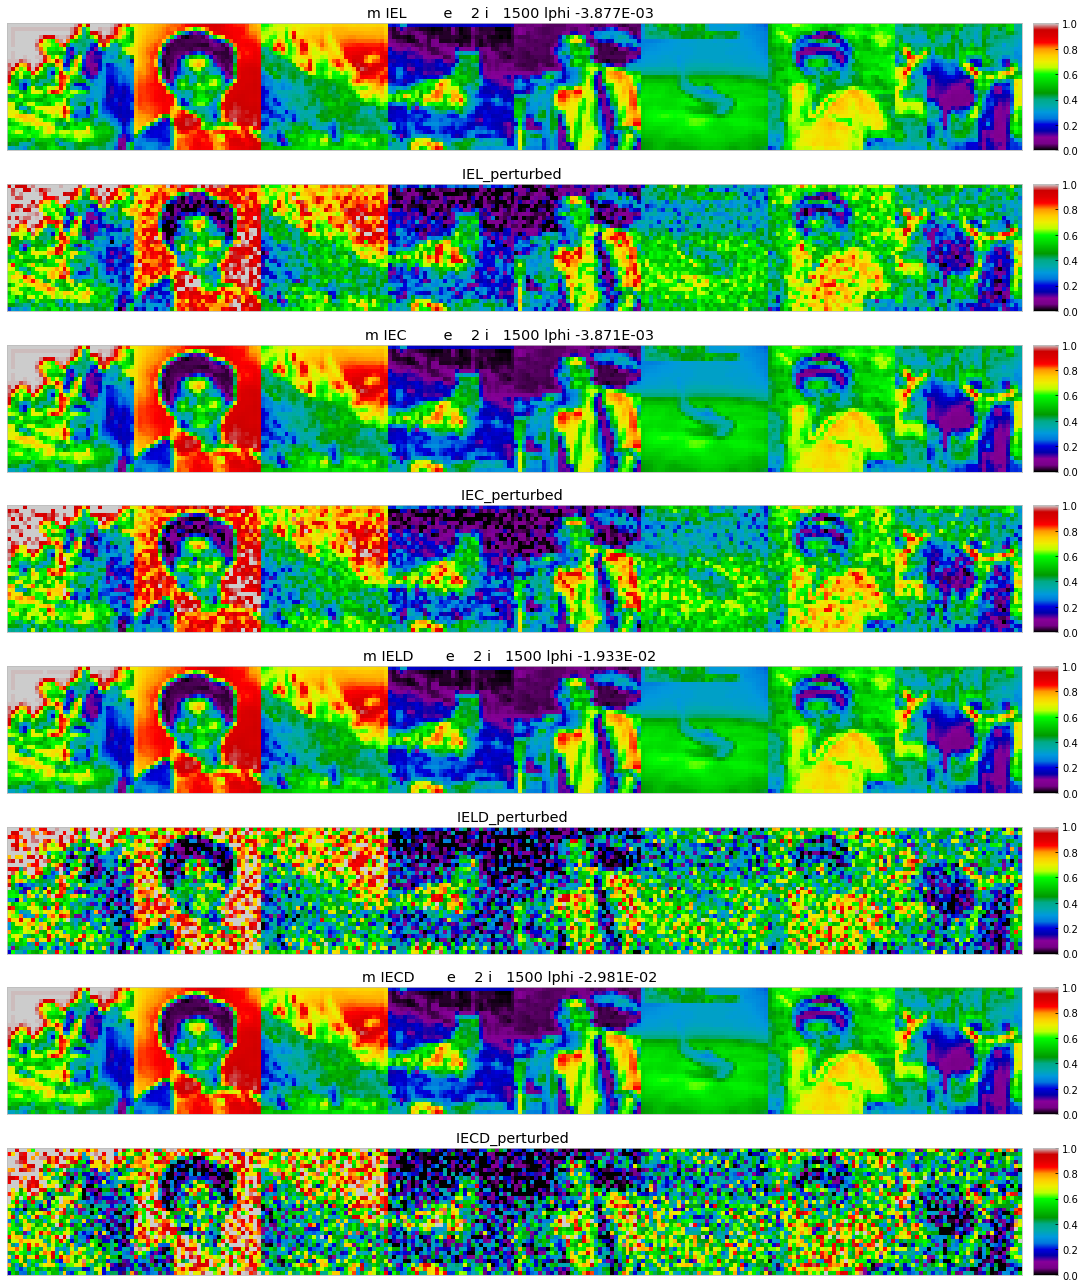

In [28]:
# Training loop

for e in range(epochs):
    i = 0
    for x, y in loader:
        with torch.no_grad():
            y = blur_gpu(x.to(device)).flatten(-3, -1)
        x = x[:,0,:,:].flatten(-2, -1).to(device)
        xhs = {}
        ldicts = {}
        for m, cur in enumerate(nets):
            # Reset gradients and do forward pass
            opts_p[cur].zero_grad()
            r = utils.projection.project_into_ball(rs[cur], 1, 2)

            xh = nets[cur].T(y)
            xe = nets[cur].T(y + r)

            # Calculate loss
            loss, ldicts[cur] = perturbation_objective(xe, xh)

            loss.backward()
            opts_p[cur].step()
            
            # Reporting
            for k, v in ldicts[cur].items():
                
                if k not in loss_trace_p[cur]:
                    loss_trace[cur][k] = []

                loss_trace_p[cur][k].append(v)


        # Plot and Report
        if i % 500 == 0:
            for cur in nets.keys():
                with torch.no_grad():
                    per = f'{cur}_perturbed'
                    r = utils.projection.project_into_ball(rs[cur], 1, 2)

                    xhs[cur] = nets[cur].T(nets[cur](xs))
                    xhs[cur] = xhs[cur].to('cpu').unflatten(-1, train.size)
                    xhs[per] = nets[cur].T(nets[cur](xs) + r)
                    xhs[per] = xhs[per].to('cpu').unflatten(-1, train.size)
            clear_output(wait=True)
            utils.reporting.plot_training(xhs, e, i, ldicts, save=False)            
        i += 1

In [29]:
# Move models to CPU
for cur, model in nets.items():
    nets[cur] = model.to('cpu')

print(f"Relative Cond:")

for k, model in nets.items():
    r = utils.projection.project_into_ball(rs[k].cpu(), 1, 2)
    YE = model.T(yt.cpu() + r)
    YH = model.T(yt.cpu())

    cond_no = utils.metrics.relative_cond_no(YH, YE, yt.cpu(), r, reduction='mean')
    
    print(f"{k:6}: {cond_no.item():2.6f}")

Relative Cond:
IEL   : 6.919568
IEC   : 6.918256
IELD  : 15.504889
IECD  : 19.276339
